# Assignment: Clustering and association rule mining

## 1. Business Understanding

Another optimization idea is to increase the revenue of the company by recommending products to customers based on their purchase history. For this purpose, the company is looking to use association rule mining to find interesting relationships between products that are frequently purchased together.
In the initial phase of the project, the company focuses on 20 internal product groups, and wants to find out which product groups act as triggers for buying items from some other product groups.

## Task

The task is split into two sub-tasks: finding optimal hub locations and finding interesting relationships between product groups.

## Task 1: Finding optimal hub locations

### Business understanding

The company operates a drone fleet for product delivery and plans to establish depots for stationing, servicing, and loading. The goal is to optimize operations by identifying the best hub locations by analyzing order location data.

### Data understanding

Here we import the dataset into pandas as a dataframe, and display first 5 rows to check data format.

In [13]:
import pandas as pd

df = pd.read_csv('drone_cust_locations.csv', sep=";")

display(df.head())

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


The dataset includes customer IDs with corresponding x and y coordinates. The coordinates are expressed as floating-point values in the range 0–1000, rather than in degrees.

### Data preparation

We clean the data by removing the ID column and then display the results.

In [14]:
df.drop(columns="clientid", inplace=True)

display(df.head(5))

,x,y
0,622.771572,164.857623
1,416.357298,630.193634
2,292.735020,567.333231
3,737.211288,166.225676
4,540.475375,682.912298


Next, we visualize the data using a seaborn scatter plot.

<Axes: xlabel='x', ylabel='y'>

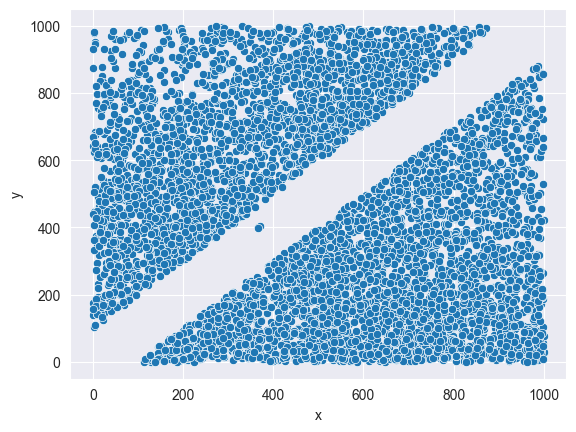

In [15]:
import seaborn as sns

sns.scatterplot(data=df, x="x", y="y")

From the plot, we can see that the residential area is divided by a river or another uninhabitable zone, such as a highway. However, there are still a few individual customers located within this area.

### Modeling

We perform K-Means clustering with 3, 5, 7 and 10 clusters to identify optimal locations for the drone stations. Cluster centers are added to the dataframe with a depot value of "center", enabling us to plot the cluster centers. A function is also defined to print out the cluster details. We also printed out the runtimes for each plot to see the difference between cluster counts.

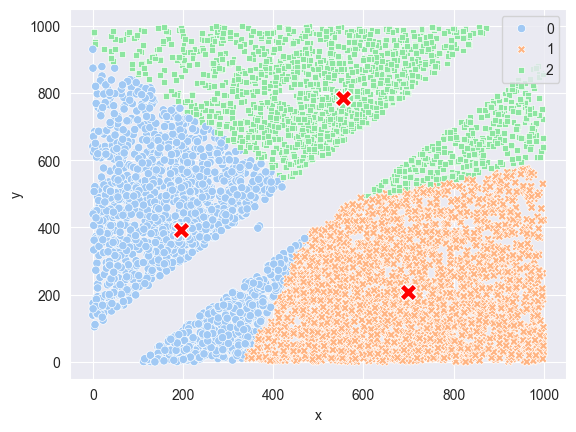

'Runtime: 0.6198 seconds'

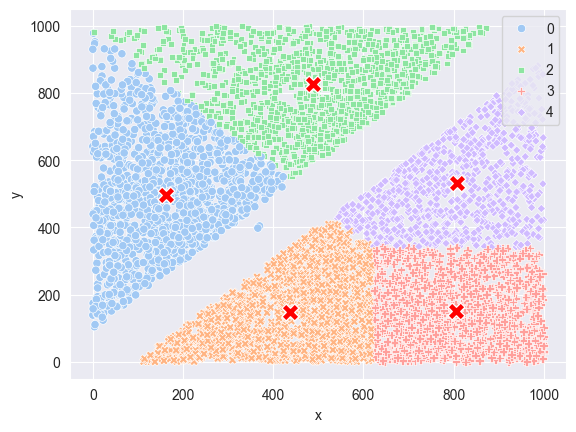

'Runtime: 1.1269 seconds'

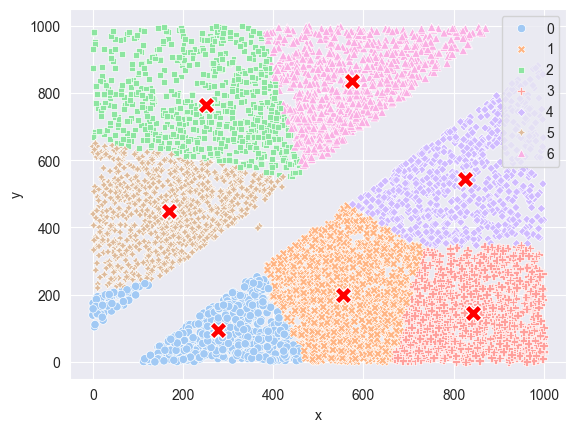

'Runtime: 0.8359 seconds'

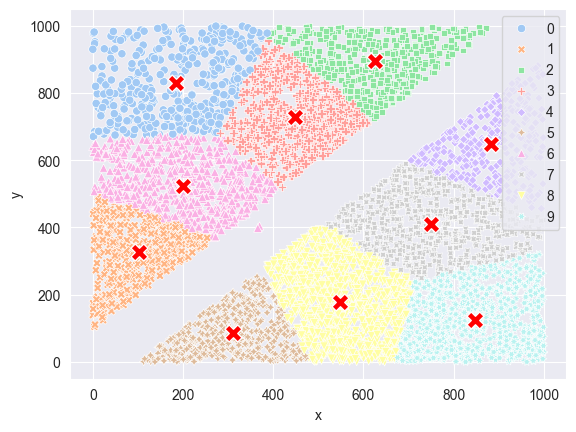

'Runtime: 0.5825 seconds'

In [16]:
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

clusters_list = [3, 5, 7, 10]

def plot_clusters(num, df):
    start_time = time.time()
    
    dff = df.copy()
    
    model = KMeans(init="random", n_clusters=num, random_state=123)
    
    model.fit(dff)
    
    dff["depot"] = model.labels_
    
    columns = ["x", "y"]
    centers = pd.DataFrame(model.cluster_centers_, columns=columns)
            
    sns.scatterplot(data=dff, x="x", y="y", hue="depot", style="depot", palette="pastel")
    
    sns.scatterplot(data=centers, x="x", y="y", color="red", marker="X", s=150)
    
    plt.show()
    
    end_time = time.time()
    runtime = end_time - start_time
    
    display(f"Runtime: {runtime:.4f} seconds")
    
for n in clusters_list:
    plot_clusters(n, df)

With more clusters the runtime seems to decrease. From the plot we can also see how the clusters form around the uninhabitable zone in the middle.

### Evaluation

We evaluate the K-Means results using WCSS (within-cluster sum of squares) for cluster counts ranging from 1 to 10.

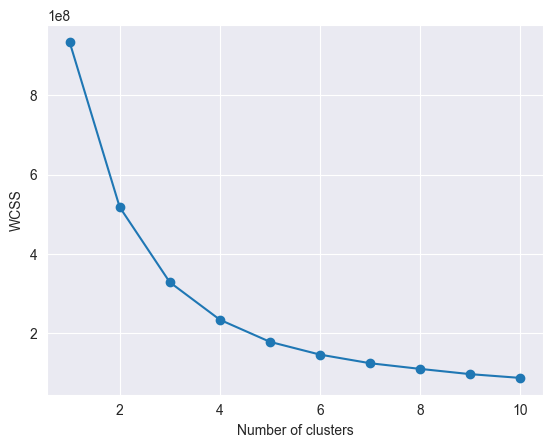

In [17]:
wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Based on the graph, 5-6 clusters appear optimal, as the WCSS decreases only marginally beyond this point.

In [18]:
from sklearn.metrics import silhouette_score

model = KMeans(init='random', n_clusters=3, random_state=42).fit(df)
labels = model.labels_
print('Silhouette score = %.2f' % silhouette_score(df, labels))

Silhouette score = 0.42


This result tells us, that the clustering results are not ideal, but are acceptable. By testing other values, we found no large increase in the score.

### Agglomerative hierarchical clustering

We applied agglomerative clustering to group customers and explore potential locations for drone hubs as an alternative to K-Means.

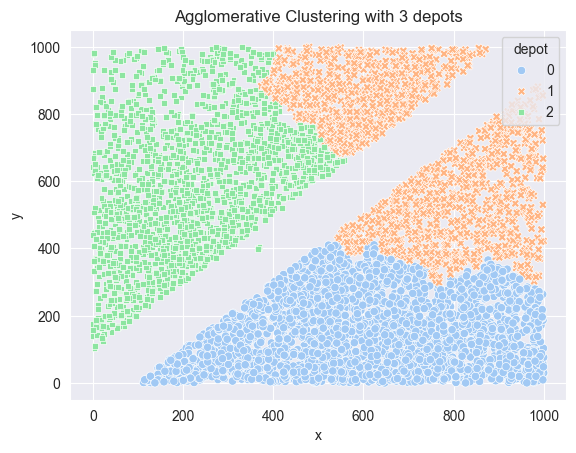

Runtime for 3 depots: 1.2220 seconds


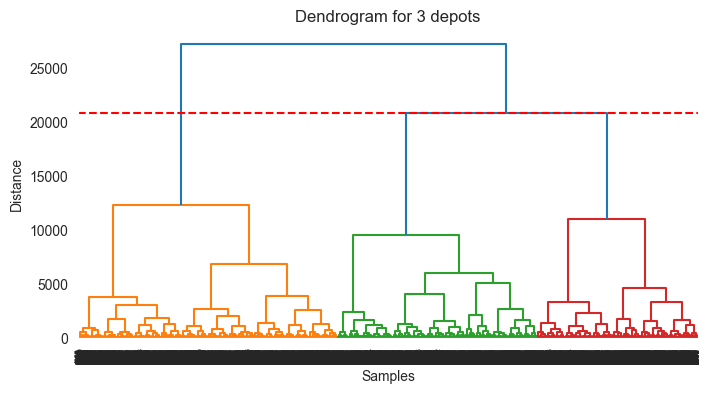

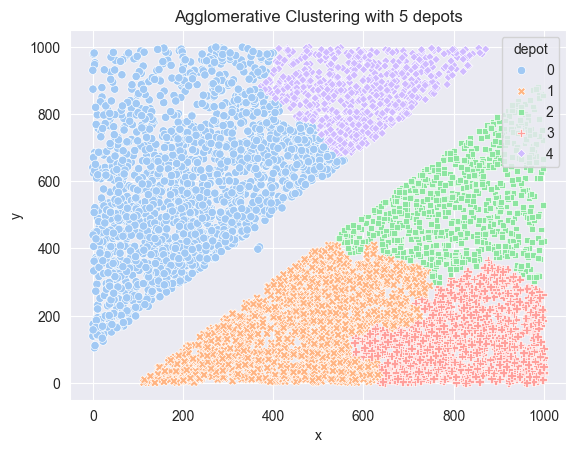

Runtime for 5 depots: 1.2294 seconds


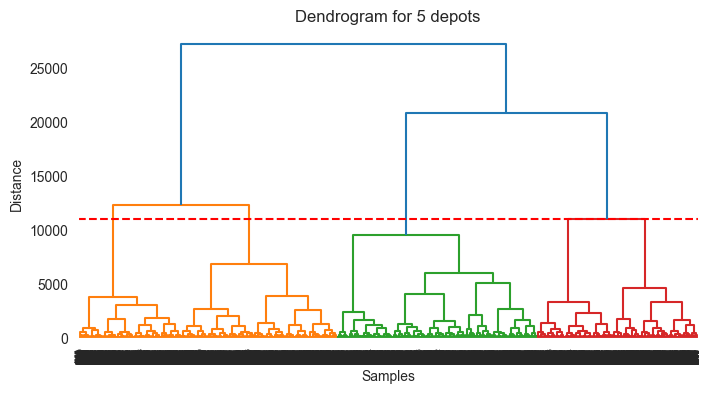

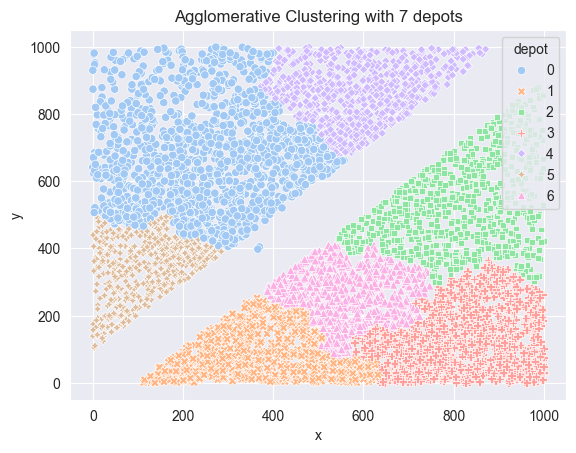

Runtime for 7 depots: 1.3761 seconds


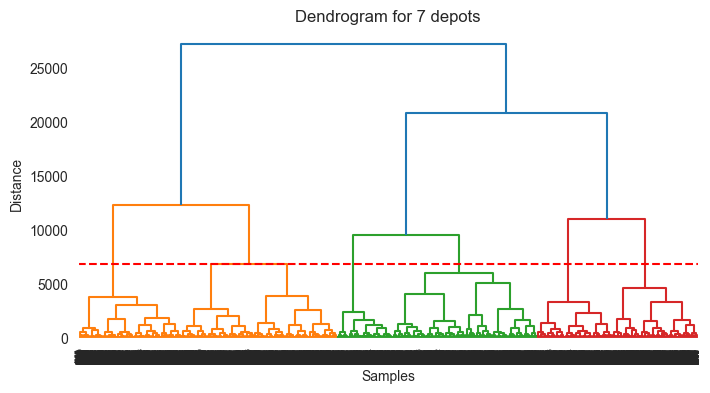

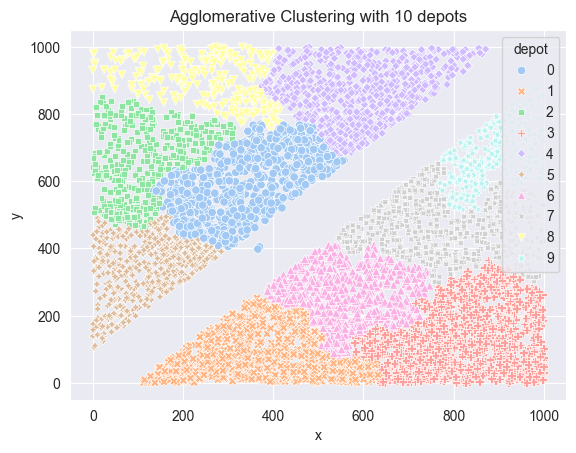

Runtime for 10 depots: 1.4973 seconds


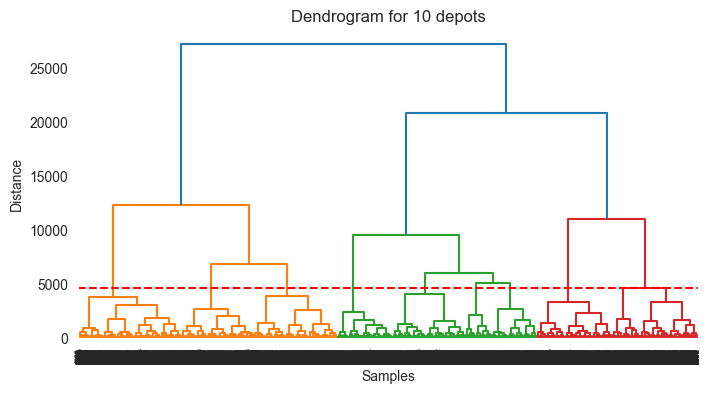

In [19]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

def hierarchical_clustering(num, df):
    start_time = time.time()
    dff = df.copy()
    
    # Agglomerative clustering
    model = AgglomerativeClustering(n_clusters=num, metric="euclidean", linkage="ward")
    dff["depot"] = model.fit_predict(dff[["x", "y"]])
    
    # Plot clusters
    sns.scatterplot(data=dff, x="x", y="y", hue="depot", style="depot", palette="pastel")
    plt.title(f"Agglomerative Clustering with {num} depots")
    plt.show()
    
    runtime = time.time() - start_time
    print(f"Runtime for {num} depots: {runtime:.4f} seconds")
    
    # Plot dendrogram
    Z = linkage(dff[["x", "y"]], method="ward")
    plt.figure(figsize=(8, 4))
    dendrogram(Z, labels=dff.index.tolist())
    plt.title(f"Dendrogram for {num} depots")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.axhline(y=Z[-num+1, 2], color="red", linestyle="--")
    plt.show()
    
for n in clusters_list:
    hierarchical_clustering(n, df)


From the plots, we can see that depot locations should follow the K-Means results, as hierarchical clustering often identified areas that were not optimally located.

## Part 2: Finding interesting relationships between product groups

### Business understanding

Next we will analyze order info based on different products on order. The idea is to find out correlations between products, and group them up based on order preferences.

### Data understanding

Now we load a new dataset into a pandas dataframe.

In [20]:
df2 = pd.read_csv('drone_prod_groups.csv')

display(df2.head(5))

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


The dataset has binary rows for 20 different products and order id.

### Data preparation

We prepare the data by replacing zeroes with False and ones with True. This prevents the model creating associations based on the 0 rows and focuses only on the purchased products. We also drop the id column.

In [21]:
df2.replace(0, False, inplace=True)
df2.replace(1, True, inplace=True)

df2.drop(columns="ID", inplace=True)

display(df2.head())

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_26456\2117737934.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2.replace(1, True, inplace=True)


,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True


### Modeling

Here we apply the Apriori algorithm to the dataset. we will play around with different values of min_support to get a result that is suitable to continue with.

In [22]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(df2, min_support=0.005, use_colnames=True)
display(frequent_itemsets)

,support,itemsets
0,0.10998,(Prod1)
1,0.13098,( Prod2)
2,0.03271,( Prod3)
3,0.03585,( Prod4)
4,0.10459,( Prod5)
...,...,...
334,0.00532,"( Prod9, Prod19, Prod15, Prod16)"
335,0.01919,"( Prod9, Prod19, Prod15, Prod20)"
336,0.00622,"( Prod9, Prod19, Prod16, Prod20)"
337,0.00567,"( Prod9, Prod19, Prod18, Prod20)"


We ended up using min_support value of 0.005 to produce a list of item sets containing 339 sets of items.

Next we will generate association rules based on the item sets. Here we will alter the value of min_threshold to produce rules set.

In [23]:
from mlxtend.frequent_patterns import association_rules

# generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# sort in descending order of confidence
rules = rules.sort_values(by='confidence', ascending=False)

display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
55,"( Prod17, Prod15)",( Prod9),0.00792,0.19853,0.00756,0.954545,4.808067,1.0,0.005988,17.632340,0.798339,0.038011,0.943286,0.496313
88,"( Prod15, Prod12, Prod5)",( Prod9),0.00963,0.19853,0.00915,0.950156,4.785956,1.0,0.007238,16.079492,0.798747,0.045978,0.937809,0.498122
99,"( Prod15, Prod19, Prod8)",( Prod9),0.00666,0.19853,0.00631,0.947447,4.772314,1.0,0.004988,15.250829,0.795758,0.031728,0.934430,0.489616
12,"( Prod15, Prod2)",( Prod9),0.01947,0.19853,0.01843,0.946584,4.767967,1.0,0.014565,15.004443,0.805959,0.092349,0.933353,0.519708
61,"( Prod15, Prod20)",( Prod9),0.02241,0.19853,0.02119,0.945560,4.762807,1.0,0.016741,14.722084,0.808150,0.106083,0.932075,0.526147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,"( Prod9, Prod19, Prod12)",( Prod15),0.01042,0.11880,0.00587,0.563340,4.741917,1.0,0.004632,2.018045,0.797424,0.047588,0.504471,0.306375
1,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664,0.541335,0.502243,0.749754
44,"( Prod9, Prod10)",( Prod15),0.02289,0.11880,0.01278,0.558322,4.699684,1.0,0.010061,1.995120,0.805661,0.099139,0.498777,0.332949
114,"( Prod14, Prod9, Prod19)",( Prod15),0.00947,0.11880,0.00524,0.553326,4.657629,1.0,0.004115,1.972805,0.792806,0.042591,0.493107,0.298717


We made a set of 133 rules based on groupings of orders in the dataset.

Next, we group values by lift, which indicates how much more likely an outcome is compared to random chance.

In [24]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)

# sort in descending order of lift
rules = rules.sort_values(by='lift', ascending=False)

display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1456,"( Prod9, Prod20)","( Prod15, Prod19)",0.03676,0.03041,0.01919,0.522035,17.166551,1.0,0.018072,2.028579,0.977687,0.399958,0.507044,0.576539
1457,"( Prod15, Prod19)","( Prod9, Prod20)",0.03041,0.03676,0.01919,0.631042,17.166551,1.0,0.018072,2.610707,0.971284,0.399958,0.616962,0.576539
1459,"( Prod15, Prod20)","( Prod9, Prod19)",0.02241,0.04996,0.01919,0.856314,17.139995,1.0,0.018070,6.611924,0.963243,0.360850,0.848758,0.620211
1454,"( Prod9, Prod19)","( Prod15, Prod20)",0.04996,0.02241,0.01919,0.384107,17.139995,1.0,0.018070,1.587273,0.991176,0.360850,0.369989,0.620211
1245,"( Prod9, Prod5)","( Prod15, Prod12)",0.02462,0.02308,0.00915,0.371649,16.102646,1.0,0.008582,1.554736,0.961572,0.237354,0.356804,0.384048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,( Prod17),( Prod18),0.05618,0.12166,0.00792,0.140975,1.158766,1.0,0.001085,1.022485,0.145168,0.046610,0.021991,0.103037
242,( Prod17),( Prod12),0.05618,0.15971,0.01034,0.184051,1.152409,1.0,0.001367,1.029832,0.140125,0.050304,0.028968,0.124397
243,( Prod12),( Prod17),0.15971,0.05618,0.01034,0.064742,1.152409,1.0,0.001367,1.009155,0.157389,0.050304,0.009072,0.124397
81,( Prod7),( Prod4),0.13499,0.03585,0.00555,0.041114,1.146838,1.0,0.000711,1.005490,0.148019,0.033577,0.005460,0.097963


## Deployment

These models could help a drone company improve delivery times and efficiency and design targeted product offers. They could also be combined to optimize warehousing when multiple products have geographical demand patterns.